  # <span style="color:red">          FACE MASK DETECTION WITH EXPLANATION</span>   😷

### Here I am going forward to write code on identifying  Face Mask Detection  with OpenCV, Keras/TensorFlow using Deep Learning and Computer Vision. Here will will be claasify the target with having face mask and without face mask.

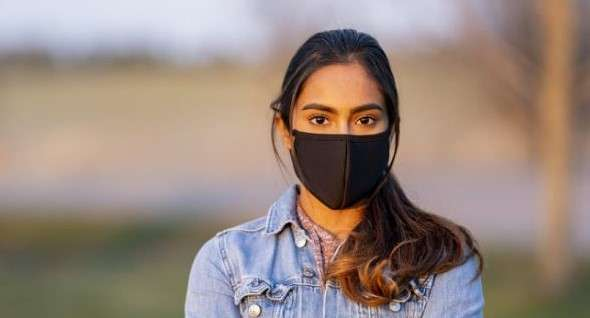

## IMPORT LIBRARIES

In [ ]:
import numpy as np 
import pandas as pd 
import os,sys
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
import seaborn as sns
import tensorflow as tf
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint

In [ ]:
pip install mtcnn

Implementation of the MTCNN face detector for Keras in Python3.4+. It is written from scratch, using as a reference the implementation of MTCNN from David Sandberg (FaceNet's MTCNN) in Facenet. It is based on the paper Zhang, K et al. (2016) [ZHANG2016]. #COLLECTED

MTCNN (Multi-task Cascaded Convolutional Neural Networks) is an algorithm consisting of 3 stages, which detects the bounding boxes of faces in an image along with their 5 Point Face Landmarks.

In [ ]:
from mtcnn.mtcnn import MTCNN

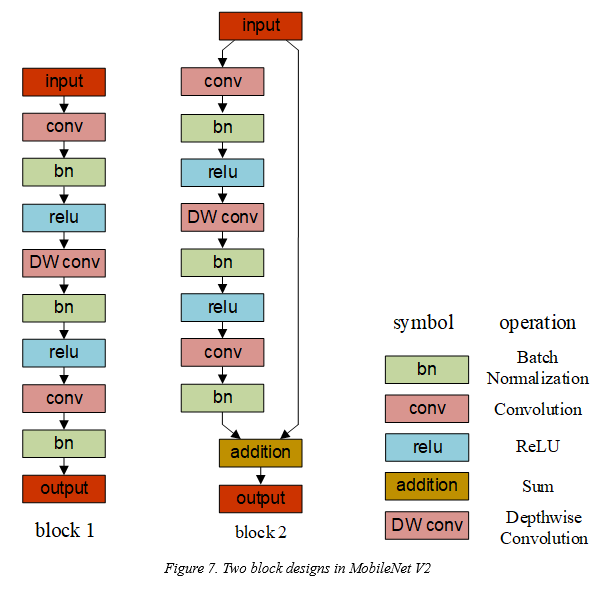

# IMPORT DATASET

In [ ]:
images=os.path.join("/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images")
annotations=os.path.join("/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations")
train=pd.read_csv(os.path.join("/kaggle/input/face-mask-detection-dataset/train.csv"))
submission=pd.read_csv(os.path.join("/kaggle/input/face-mask-detection-dataset/submission.csv"))

In [ ]:
print(train.shape)
print('  ')
print(train['classname'].value_counts())
print('  ')
print(train.info())


In [ ]:
train.head(10)

In [ ]:
classes = train["classname"].unique()
print("Total Classes: ",len(classes))
print("\n> Classes <\n",classes)



plt.figure(figsize=(14,8))
plt.title('Class Distribution', fontsize= 20)
sns.countplot(x = "classname", data = train)

Here we can see, there are two classes in the target  

In [ ]:
ax = sns.catplot(x='classname',kind='count',data=train,orient="h",height=10,aspect=2)
ax.fig.suptitle('Count of Classnames',fontsize=16,color="r")
ax.fig.autofmt_xdate()

In [ ]:
print(len(os.listdir(images)))
print("      ")
print(len(os.listdir(annotations)))

In [ ]:
a=os.listdir(images)
b=os.listdir(annotations)
a.sort()
b.sort()

In [ ]:
print(len(a),len(a))

In [ ]:
train_images=a[1698:]
test_images=a[:1698]


In [ ]:
print(test_images[0])
print(train_images[5])

In [ ]:
img=plt.imread(os.path.join(images,test_images[5]))
plt.imshow(img)
plt.show()

In [ ]:
img=plt.imread(os.path.join(images,train_images[15]))
plt.imshow(img)
plt.show()

In [ ]:
options=['face_with_mask','face_no_mask']
train= train[train['classname'].isin(options)]
train.sort_values('name',axis=0,inplace=True)

In [ ]:
bbox=[]
for i in range(len(train)):
    arr=[]
    for j in train.iloc[i][["x1",'x2','y1','y2']]:
        arr.append(j)
    bbox.append(arr)
train["bbox"]=bbox  
def get_boxes(id):
    boxes=[]
    for i in train[train["name"]==str(id)]["bbox"]:
        boxes.append(i)
    return boxes
print(get_boxes(train_images[2]))


#####################################

image=train_images[2]
img=plt.imread(os.path.join(images,image))
fig,ax = plt.subplots(1)
ax.imshow(img)
boxes=get_boxes(image)
for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

In [ ]:
image=train_images[4]
img=plt.imread(os.path.join(images,image))
fig,ax = plt.subplots(1)
ax.imshow(img)
boxes=get_boxes(image)
for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

### Preparing Training Data/ Images || Augmentation

In [ ]:
img_size=50
data=[]
path='/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/'
def create_data():
       for i in range(len(train)):
            arr=[]
            for j in train.iloc[i]:
                   arr.append(j)
            img_array=cv2.imread(os.path.join(images,arr[0]),cv2.IMREAD_GRAYSCALE)
            crop_image = img_array[arr[2]:arr[4],arr[1]:arr[3]]
            new_img_array=cv2.resize(crop_image,(img_size,img_size))
            data.append([new_img_array,arr[5]])
            
create_data()

In [ ]:

#plt.imshow(data[0][0])


In [ ]:
x=[]
y=[]
for features, labels in data:
    x.append(features)
    y.append(labels)
from sklearn.preprocessing import LabelEncoder
lbl=LabelEncoder()
y=lbl.fit_transform(y)

In [ ]:
x=np.array(x).reshape(-1,50,50,1)
x=tf.keras.utils.normalize(x,axis=1)
from keras.utils import to_categorical
y = to_categorical(y)

## MODEL FITTING

In [ ]:
from keras.layers import LSTM
model=Sequential()
model.add(Conv2D(100,(3,3),input_shape=x.shape[1:],activation='relu',strides=2))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

In [ ]:
opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) 
my_model = model.fit(x,y,epochs=30,batch_size=5)

In [ ]:
detector=MTCNN()
img=plt.imread(os.path.join(images,test_images[9]))
face=detector.detect_faces(img)
for face in face:
        bounding_box=face['box']
        x=cv2.rectangle(img,
              (bounding_box[0], bounding_box[1]),
              (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
              (0,155,255),
              10)
        plt.imshow(x)

##### 

In [ ]:
img=plt.imread(os.path.join(images,test_images[25]))
face=detector.detect_faces(img)
for face in face:
        bounding_box=face['box']
        x=cv2.rectangle(img,
              (bounding_box[0], bounding_box[1]),
              (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
              (0,155,255),
              10)
        plt.imshow(x)

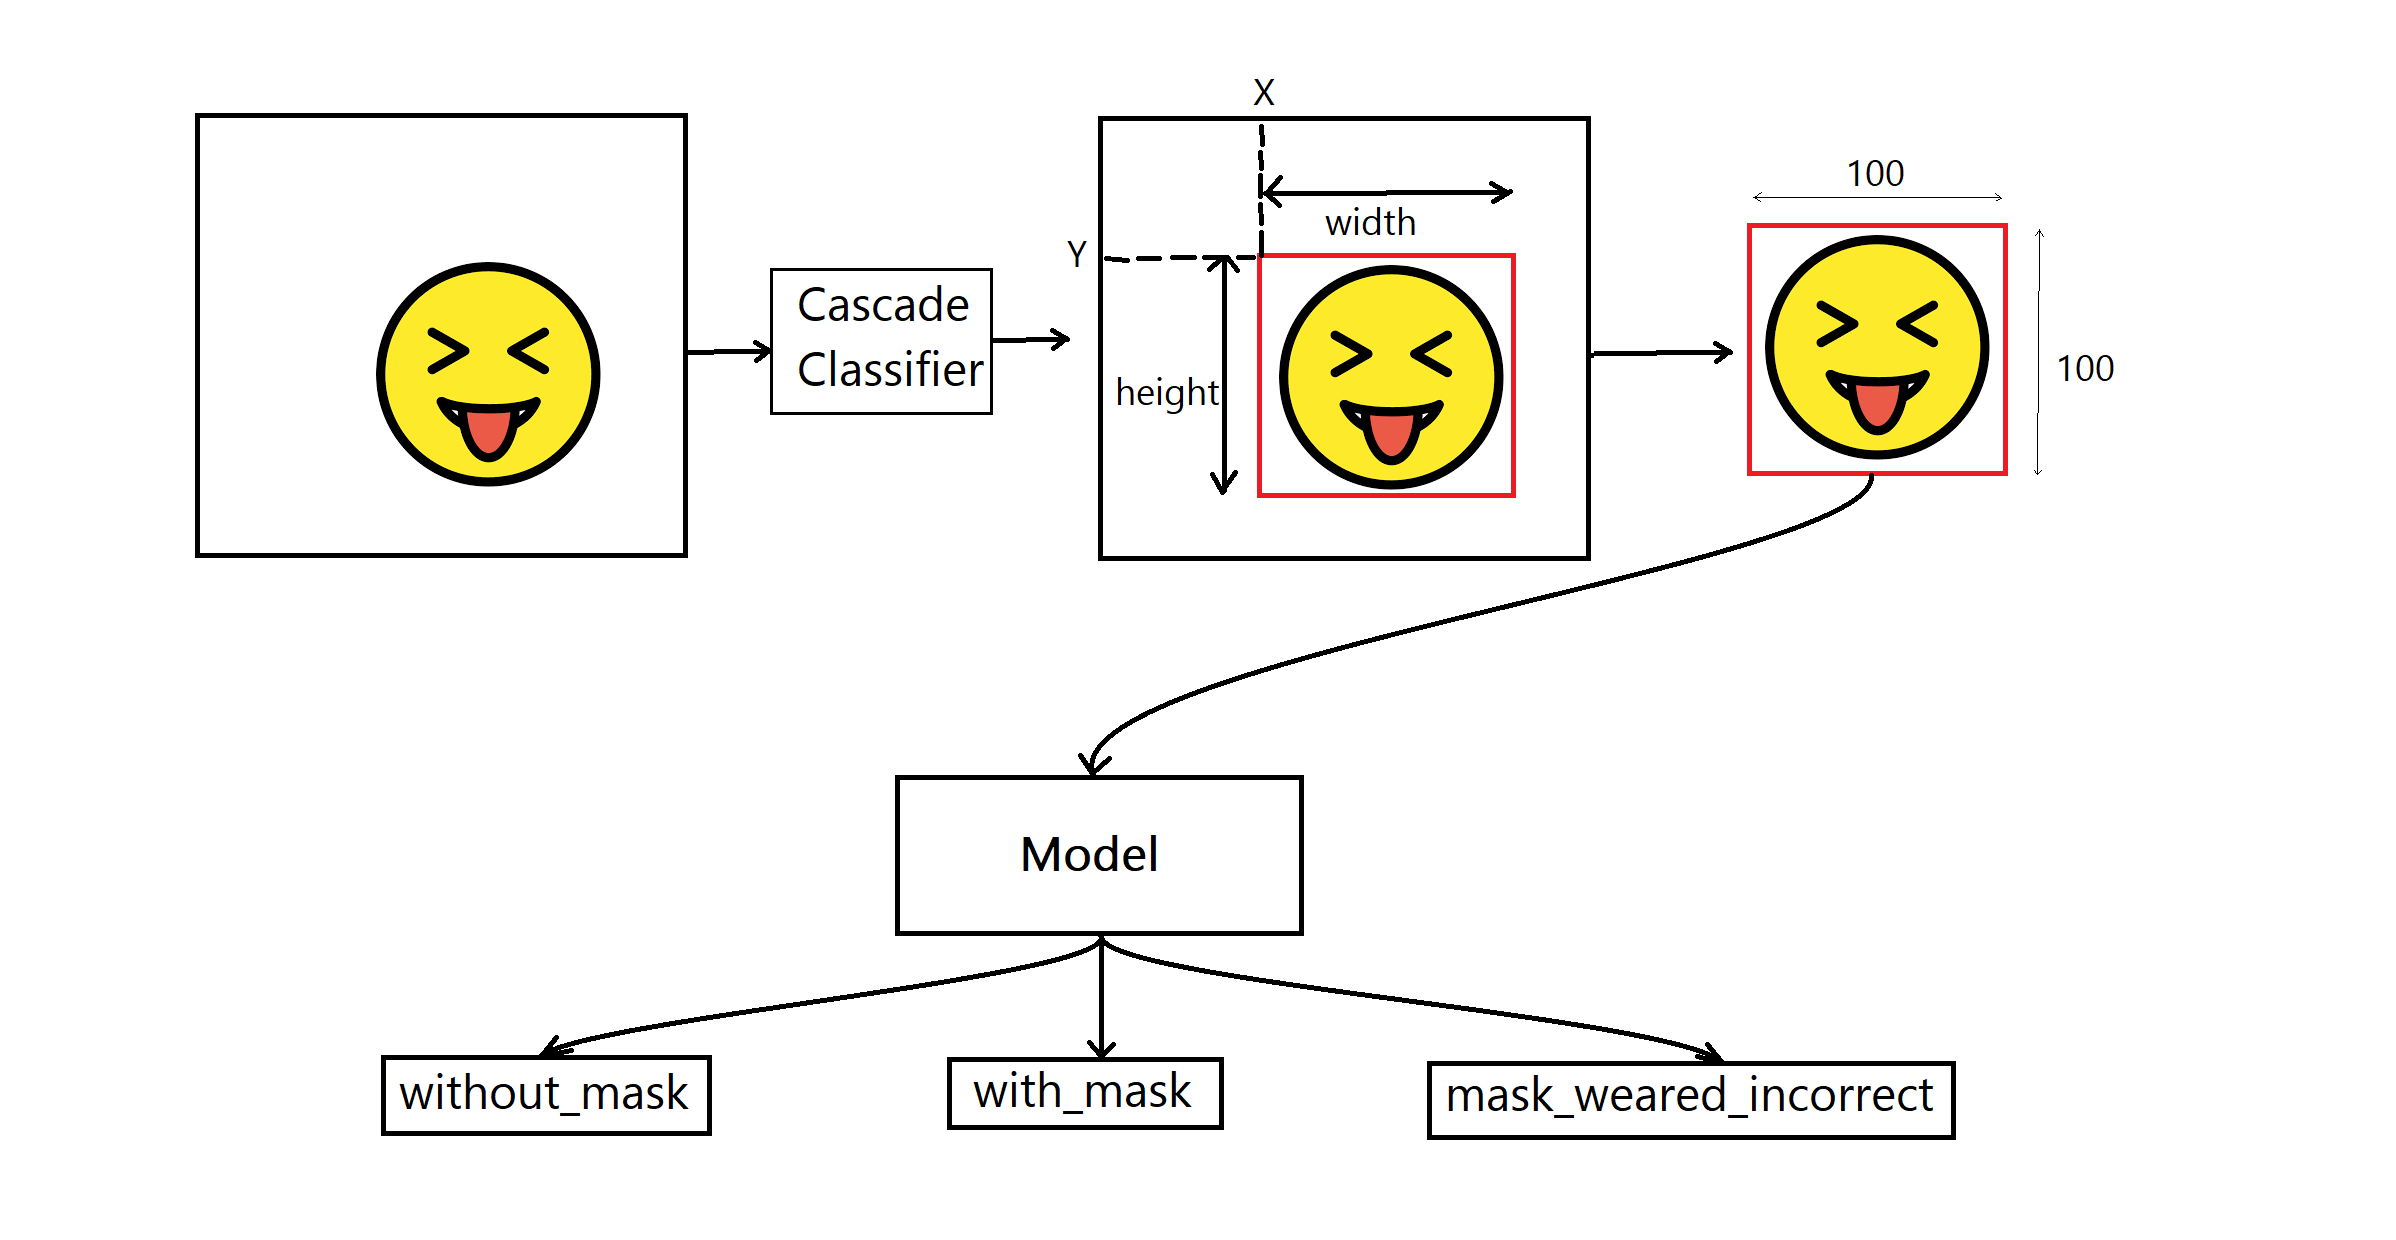

In [ ]:
detector=MTCNN()
test_df=[]
for image in test_images:
    img=plt.imread(os.path.join(images,image))
    faces=detector.detect_faces(img)
    test=[]
    for face in faces:
        bounding_box=face['box']
        test.append([image,bounding_box])
    test_df.append(test)
test=[]
for i in test_df:
    if len(i)>0:
        if len(i)==1:
            test.append(i[0])
        else:
            for j in i:
                test.append(j)  
sub=[]
rest_image=[]
for i in test:
    sub.append(i[0])
for image in test_images:
    if image not in sub:
        rest_image.append(image) 
detector=MTCNN()
test_df_=[]
for image in rest_image:
    img=cv2.imread(os.path.join(images,image))
    faces=detector.detect_faces(img)
    test_=[]
    for face in faces:
        bounding_box=face['box']
        test_.append([image,bounding_box])
    test_df_.append(test_) 
for i in test_df_:
    if len(i)>0:
        if len(i)==1:
            test.append(i[0])
        else:
            for j in i:
                test.append(j) 

In [ ]:
negative=[]
for i in test:
    for j in i[1]:
        if j<0:
            negative.append(i)

In [ ]:
test_data=[]
def create_test_data():
            for j in test:
                if j not in negative:
                    img=cv2.imread(os.path.join(images,j[0]),cv2.IMREAD_GRAYSCALE)
                    img=img[j[1][1]:j[1][1]+j[1][3],j[1][0]:j[1][0]+j[1][2]]
                    new_img=cv2.resize(img,(50,50))
                    new_img=new_img.reshape(-1,50,50,1)
                    predict=model.predict(new_img)
                    test_data.append([j,predict])

create_test_data()

In [ ]:
image=[]
classname=[]
for i,j in test_data:
    classname.append(np.argmax(j))
    image.append(i)
df=pd.DataFrame(columns=['image','classname'])
df['image']=image
df['classname']=classname
df['classname']=lbl.inverse_transform(df['classname'])
image=[]
x1=[]
x2=[]
y1=[]
y2=[]
for i in df['image']:
    image.append(i[0])
    x1.append(i[1][0])
    x2.append(i[1][1])
    y1.append(i[1][2])
    y2.append(i[1][3])
df['name']=image
df['x1']=x1
df['x2']=x2
df['y1']=y1
df['y2']=y2    
df.drop(['image'],axis=1,inplace=True)

In [ ]:
df.sort_values('name',axis=0,inplace=True,ascending=False)
df.to_csv('submission_1.csv')

# Using Transfer Learning as an Alternative

By rethinking the inception architecture, computational efficiency and fewer parameters are realized. With fewer parameters, 42-layer deep learning network, with similar complexity as VGGNet, can be achieved.

> 
> “The Inception deep convolutional architecture was introduced as GoogLeNet in (Szegedy et al. 2015a), here named Inception-v1. Later the Inception architecture was refined in various ways, first by the introduction of batch normalization (Ioffe and Szegedy 2015) (Inception-v2). Later by additional factorization ideas in the third iteration (Szegedy et al. 2015b) which will be referred to as Inception-v3 in this report.”

In [ ]:

pre_trained_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(100, 100, 3))

pre_trained_model.summary()

In [ ]:
for layer in pre_trained_model.layers:
    layer.trainable = False
    
last_layer = pre_trained_model.get_layer('mixed7')
print('Last layer output shape :', last_layer.output_shape)
last_output = last_layer.output

In [ ]:

x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
#The Final layer with 3 outputs for 3 categories
x = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=x)

model.summary()

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(50,activation='relu'))
#Dense layer of 64 neurons
model.add(Dense(2,activation='softmax'))
#The Final layer with two outputs for two categories

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# WORK IN PROGRESS...

## Reference :
* https://www.kaggle.com/ayushimishra2809/face-mask-detection
* https://github.com/FarhanSadaf/face-mask-detection
* https://www.pyimagesearch.com/2020/05/04/covid-19-face-mask-detector-with-opencv-keras-tensorflow-and-deep-learning/



# <span style="color:blue">If you like  the Kernal please hit Upvote </span>  ⥣  🧡


    
